In [21]:
import torch
from torch import optim
from IPython import display

import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


In [23]:
# %%time

def intersection(p1, p2, p3, p4):
    a = p2 - p1
    b = p3 - p4
    c = p1 - p3
    
    ax, ay = a[:,0], a[:,1]
    bx, by = b[:,0], b[:,1]
    cx, cy = c[:,0], c[:,1]
    denom = (ay*bx-ax*by)
    alpha = (by*cx-bx*cy)
    beta = (ax*cy-ay*cx)
#     alpha = (by*cx-bx*cy) / denom
#     beta = (ax*cy-ay*cx) / denom
    return alpha, beta, denom
    
    
def getCrossings(pos, G, id2index):
    edges = list(G.edges)
    m = len(edges)
    
    ## option 1 faster
    edges = torch.stack([torch.cat([pos[id2index[n1]], pos[id2index[n2]]]) for n1, n2 in edges])
    e0 = edges.repeat(1, m).view(-1,edges.shape[1])
    e1 = edges.repeat(m, 1)
    p1, p2, p3, p4 = e0[:,:2], e0[:, 2:], e1[:,:2], e1[:,2:] 
    alpha, beta, denom = intersection(p1, p2, p3, p4)
    alphaInRange1 = torch.logical_and(denom > 0, torch.logical_and(    0<alpha, alpha<denom)) 
    alphaInRange2 = torch.logical_and(denom < 0, torch.logical_and(denom<alpha, alpha<0)) 
    betaInRange1 = torch.logical_and(denom > 0, torch.logical_and(    0<beta, beta<denom)) 
    betaInRange2 = torch.logical_and(denom < 0, torch.logical_and(denom<beta, beta<0    )) 
    alphaInRange = torch.logical_or(alphaInRange1, alphaInRange2)
    betaInRange = torch.logical_or(betaInRange1, betaInRange2)
    isValid = torch.logical_and(alphaInRange, betaInRange)
    alpha = alpha[isValid].view(-1, 1)
    beta = beta[isValid].view(-1, 1)
    p1 = p1[isValid,:] 
    p2 = p2[isValid,:]
    denom = denom[isValid].view(-1, 1)
    crossings = p1 + alpha/denom*(p2-p1)
    return crossings, alpha, beta, denom

#     ## option 2 slower
#     e0 = []
#     e1 = []
#     for i, e0_i in enumerate(edges):
#         e0_i = torch.cat([pos[id2index[e0_i[0]]], pos[id2index[e0_i[1]]]])
#         for e1_i in edges[i+1:]:
#             e1_i = torch.cat([pos[id2index[e1_i[0]]], pos[id2index[e1_i[1]]]])
#             e0.append(e0_i)
#             e1.append(e1_i)
#     e0 = torch.stack(e0)
#     e1 = torch.stack(e1)
#     p1, p2, p3, p4 = e0[:,:2], e0[:, 2:], e1[:,:2], e1[:,2:] 
#     alpha, beta, crossings = intersection(p1, p2, p3, p4)
#     return crossings
   

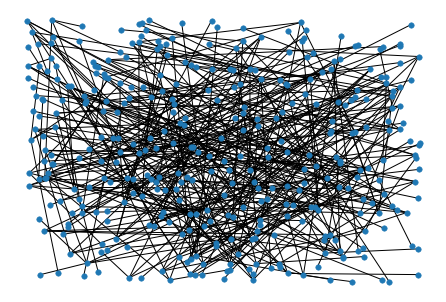

In [27]:
G = nx.balanced_tree(3,5)
n = len(G.nodes())
id2index = {node_id: i for i, node_id in enumerate(G.nodes)}
index2id = {v: k for k,v in id2index.items()}
pos0 = nx.random_layout(G)
# pos0 = nx.spring_layout(G)

nx.draw(G, pos=pos0, node_size=30)
plt.show()

In [30]:
pos = np.array([pos0[node_id] for node_id in G], dtype=np.float32)
pos = torch.from_numpy(pos)
pos.requires_grad_(True)

optimizer = optim.SGD([pos], lr=1e-3, momentum=0.9, nesterov=True)

epochBar = tqdm(range(100))

In [34]:
crossings.shape

torch.Size([11830, 2])

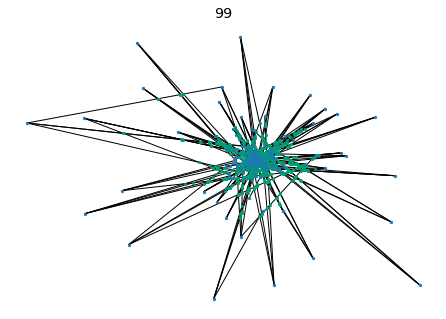

In [31]:

for i in epochBar:
    crossings, alpha, beta, denom = getCrossings(pos, G, id2index)
    
    display.clear_output(wait=True)
    nx.draw(G, pos={index2id[i]:p.detach().numpy() for i, p in enumerate(pos)}, node_size=8)
    plt.scatter(crossings[:,0].detach(), crossings[:,1].detach(), c='C1', s=5)
    plt.title(i)
    plt.show()
    
    loss = crossings.pow(2).sum()
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    
# display.clear_output(wait=True)
# nx.draw(G, pos={index2id[i]:p.detach().numpy() for i, p in enumerate(pos)}, node_size=30)
# plt.scatter(crossings[:,0].detach(), crossings[:,1].detach(), c='C1', s=10)
# plt.title(i)
# plt.show()

---